In [1]:
# Generate test classification dataset with 1000 rows 
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from collections import Counter
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, n_classes=3, random_state=1)
# summarize the dataset
print(X.shape, y.shape)
print(Counter(y))

(1000, 10) (1000,)
Counter({1: 334, 2: 334, 0: 332})


In [2]:
#The LogisticRegression class can be configured for multinomial logistic regression by setting the “multi_class” argument to “multinomial” and the “solver” argument 
#to a solver that supports multinomial logistic regression, such as “lbfgs“.
# define the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X, y)

LogisticRegression(multi_class='multinomial')

In [3]:
# define the model evaluation procedure
# We will use three repeats with 10 folds, which is a good default, and evaluate model performance using classification accuracy given that the classes are balanced.
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuracy: 0.681 (0.042)


In [4]:
# Prediction using trained model
# define a single row of input data
row = [1.89149379, -0.39847585, 1.63856893, 0.01647165, 1.51892395, -3.52651223, 1.80998823, 0.58810926, -0.02542177, -0.52835426]
# predict the class label
yhat = model.predict([row])
# summarize the predicted class
print('Predicted Class: %d' % yhat[0])

Predicted Class: 1


In [5]:
# A benefit of multinomial logistic regression is that it can predict calibrated probabilities across all known class labels in the dataset.
#This can be achieved by calling the predict_proba() function on the model.
yhat = model.predict_proba([row])
# summarize the predicted probabilities
print('Predicted Probabilities: %s' % yhat[0])

Predicted Probabilities: [0.16470456 0.50297138 0.33232406]


## Tune Penalty for Multinomial Logistic Regression

An important hyperparameter to tune for multinomial logistic regression is the penalty term. This term imposes pressure on the model to seek smaller model weights. This is achieved by adding a weighted sum of the model coefficients to the loss function, encouraging the model to reduce the size of the weights along with the error while fitting the model.

A popular type of penalty is the L2 penalty that adds the (weighted) sum of the squared coefficients to the loss function. A weighting of the coefficients can be used that reduces the strength of the penalty from full penalty to a very slight penalty.

By default, the LogisticRegression class uses the L2 penalty with a weighting of coefficients set to 1.0. The type of penalty can be set via the “penalty” argument with values of “l1“, “l2“, “elasticnet” (e.g. both), although not all solvers support all penalty types. The weighting of the coefficients in the penalty can be set via the “C” argument.

 define the multinomial logistic regression model with a default penalty
LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=1.0)

The weighting for the penalty is actually the inverse weighting, perhaps penalty = 1 – C.

C : float, default=1.0
Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.


This means that values close to 1.0 indicate very little penalty and values close to zero indicate a strong penalty. A C value of 1.0 may indicate no penalty at all.

C close to 1.0: Light penalty.
C close to 0.0: Strong penalty.
The penalty can be disabled by setting the “penalty” argument to the string “none“.

We will explore the L2 penalty with weighting values in the range from 0.0001 to 1.0 on a log scale, in addition to no penalty or 0.0.


>0.0000 0.777 (0.037)
>0.0001 0.683 (0.049)
>0.0010 0.762 (0.044)
>0.0100 0.775 (0.040)
>0.1000 0.774 (0.038)
>1.0000 0.777 (0.037)


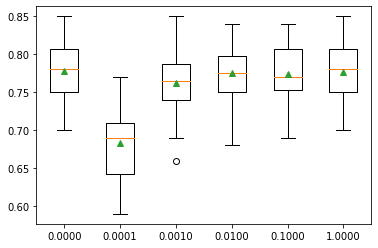

In [6]:
# get the dataset
def get_dataset():
    X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1, n_classes=3)
    return X, y
 
# get a list of models to evaluate
def get_models():
    models = dict()
    for p in [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0]:
    # create name for model
        key = '%.4f' % p
        #turn off penalty in some cases
        if p == 0.0:
            # no penalty in this case
            models[key] = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='none')
        else:
            models[key] = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=p)
    return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model and collect the scores
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize progress along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()
# In this case, we can see that a C value of 1.0 has the best score of about 77.7 percent, 
#which is the same as using no penalty that achieves the same score.

### Conclusion: A box and whisker plot is created for the accuracy scores for each configuration and all plots are shown side by side on a figure on the same scale for direct comparison.

In this case, we can see that the larger penalty we use on this dataset (i.e. the smaller the C value), the worse the performance of the model.